# ROC curves

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve, roc_auc_score

from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Settings

In [2]:
filenames = [
    "carl_fix",
    "alices_fix",
    "carl_mass",
    "alices_mass",
    "carl_align",
    "alices_align",
    "carl_full",
    "alices_full",
    "alices_full_alpha2e6",
    "alices_full_alpha2e5",
    "alices_full_alpha2e3",
    "alices_full_alpha2e2",
    "alices_full_lr1e5",
    "alices_full_lr3e5",
    "alices_full_lr3e4",
    "alices_full_lr1e3",
    "alices_full_sgd1e2",
    "alices_full_sgd1e1",
    "alices_full_batchsize256",
    "alices_full_deep",
    "alices_full_fromscratch",
]
settings = ["fix"] * 4 + ["mass"] * 6 + ["align"] * 4 + ["full"] * 10
labels = [
    "Fix:   CARL",
    "       ALICES",
    "Mass:  CARL",
    "       ALICES",
    "Align: CARL",
    "       ALICES",
    "Full:  CARL",
    "       ALICES",
    r"       (smallest $\alpha$)",
    r"       (small $\alpha$)",
    r"       (large $\alpha$)",
    r"       (largest $\alpha$)",
    "       (smallest LR)",
    "       (small LR)",
    "       (large LR)",
    "       (largest LR)",
    "       (SGD, small LR)",
    "       (SGD, large LR)",
    "       (large batch size)",
    "       (deep)",
    "       (no pretraining)",
]
colors = ["C0"] * 2 + ["C1"] * 2 + ["C2"] * 2 + ["C3"] *2 + ["C4"] *4 + ["C5"] *4 + ["C6"] *2+ ["C7"] *3
lss = ["-", "--"] * 4 + ["-", "--", "-.", ":"] * 4
alphas = [1.] * 8 + [1.0]*13


In [3]:
show_summary = [1,3,5,16]
summary_labels=["Fix", "Mass", "Align", "Full"]

## ROC curve function

In [4]:
def make_roc_curve(name, setting, f_sub_min=None, f_sub_max=None, beta_min=None, beta_max=None):
    llr0 = np.load("../data/results/llr_{}_prior.npy".format(name))
    llr1 = np.load("../data/results/llr_{}_shuffledprior.npy".format(name))
    
    if f_sub_min is not None or f_sub_max is not None or beta_min is not None or beta_max is not None:
        theta0 = np.load("../data/samples/theta_test_{}_prior.npy".format(setting))
        theta1 = np.load("../data/results/shuffled_theta_{}_shuffledprior.npy".format(name))
    
        cut0 = np.ones(llr0.shape[0], dtype=np.bool)
        cut1 = np.ones(llr1.shape[0], dtype=np.bool)
        
        if f_sub_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] >= f_sub_min)
            cut1 = np.logical_and(cut1, theta1[:, 0] >= f_sub_min)
            
        if f_sub_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] < f_sub_max)
            cut1 = np.logical_and(cut1, theta1[:, 0] < f_sub_max)
            
        if beta_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] >= beta_min)
            cut1 = np.logical_and(cut1, theta1[:, 1] >= beta_min)
            
        if beta_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] < beta_max)
            cut1 = np.logical_and(cut1, theta1[:, 1] < beta_max)
            
        llr0 = llr0[cut0]
        llr1 = llr1[cut1]
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0,llr1),0)
    s = s_from_r(np.exp(llr))
    
    fpr, tpr, _ = roc_curve(y, s)
    
    return fpr, tpr


In [5]:
def roc_auc(name, setting, f_sub_min=None, f_sub_max=None, beta_min=None, beta_max=None):
    llr0 = np.load("../data/results/llr_{}_prior.npy".format(name))
    llr1 = np.load("../data/results/llr_{}_shuffledprior.npy".format(name))
    
    if f_sub_min is not None or f_sub_max is not None or beta_min is not None or beta_max is not None:
        theta0 = np.load("../data/samples/theta_test_{}_prior.npy".format(setting))
        theta1 = np.load("../data/results/shuffled_theta_{}_shuffledprior.npy".format(name))
    
        cut0 = np.ones(llr0.shape[0], dtype=np.bool)
        cut1 = np.ones(llr1.shape[0], dtype=np.bool)
        
        if f_sub_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] >= f_sub_min)
            cut1 = np.logical_and(cut1, theta1[:, 0] >= f_sub_min)
            
        if f_sub_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] < f_sub_max)
            cut1 = np.logical_and(cut1, theta1[:, 0] < f_sub_max)
            
        if beta_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] >= beta_min)
            cut1 = np.logical_and(cut1, theta1[:, 1] >= beta_min)
            
        if beta_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] < beta_max)
            cut1 = np.logical_and(cut1, theta1[:, 1] < beta_max)
            
        llr0 = llr0[cut0]
        llr1 = llr1[cut1]
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0,llr1),0)
    s = s_from_r(np.exp(llr))
    
    return roc_auc_score(y, s)


## Data for overall ROC curve

In [6]:
rocs = []
roc_aucs = []

for filename, setting in zip(filenames, settings):
    try:
        rocs.append(make_roc_curve(filename, setting))
        roc_aucs.append(roc_auc(filename, setting))
    except FileNotFoundError as e:
        print(e)
        # print(filename, "not found")
        rocs.append(None)
        roc_aucs.append(None)

[Errno 2] No such file or directory: '../data/results/llr_alices_full_alpha2e6_prior.npy'
[Errno 2] No such file or directory: '../data/results/llr_alices_full_deep_prior.npy'


## Plot overall ROC curve

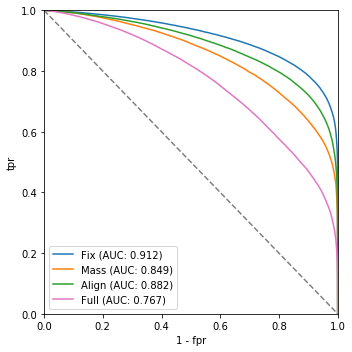

In [7]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
for i, label in zip(show_summary, summary_labels):
    if rocs[i] is not None:
        plt.plot(1. - rocs[i][0], rocs[i][1], c=colors[i], lw=1.5, ls="-", label=label + " (AUC: {:.3f})".format(roc_aucs[i]))

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")
plt.xlim(0.,1.)
plt.ylim(0.,1.)

plt.tight_layout()
plt.savefig("../figures/roc_summary.pdf")


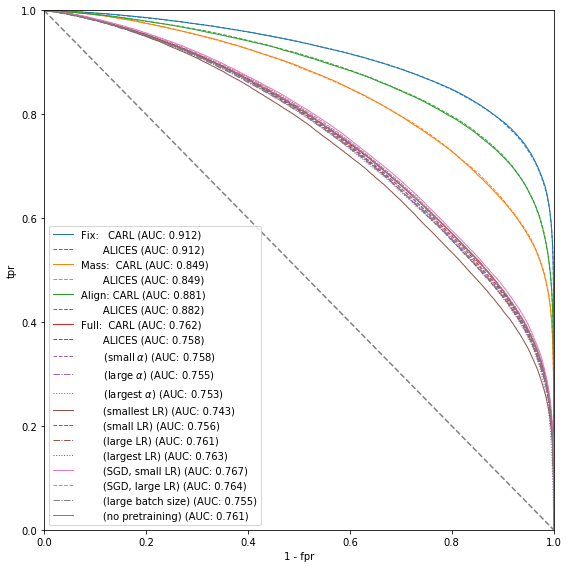

In [8]:
fig = plt.figure(figsize=(8,8))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
for roc, auc, label, color, ls, alpha in zip(rocs, roc_aucs, labels, colors, lss, alphas):
    if roc is not None:
        plt.plot(1. - roc[0], roc[1], c=color, lw=1., ls=ls, alpha=alpha, label=label + " (AUC: {:.3f})".format(auc))

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")
plt.xlim(0.,1.)
plt.ylim(0.,1.)

plt.tight_layout()
plt.savefig("../figures/roc_all.pdf")


## ROC AUC for different parameter regions

In [9]:
f_sub_edges = np.linspace(0.001, 0.2, 10)
beta_edges = np.linspace(-2.5, -1.5, 10)

f_sub_min_1d = f_sub_edges[:-1]
f_sub_max_1d = f_sub_edges[1:]
beta_min_1d = beta_edges[:-1]
beta_max_1d = beta_edges[1:]


In [10]:
roc_auc_regions = np.empty((len(show_summary), len(f_sub_min_1d), len(beta_min_1d)))

for k, n in enumerate(show_summary):
    for i, (f_sub_min, f_sub_max) in enumerate(zip(f_sub_min_1d, f_sub_max_1d)):
        for j, (beta_min, beta_max) in enumerate(zip(beta_min_1d, beta_max_1d)):
            try:
                roc_auc_regions[k, i, j] = roc_auc(
                    filenames[n],
                    settings[n],
                    beta_min=beta_min,
                    beta_max=beta_max,
                    f_sub_min=f_sub_min,
                    f_sub_max=f_sub_max
                )
            except FileNotFoundError as e:
                print(e)
    

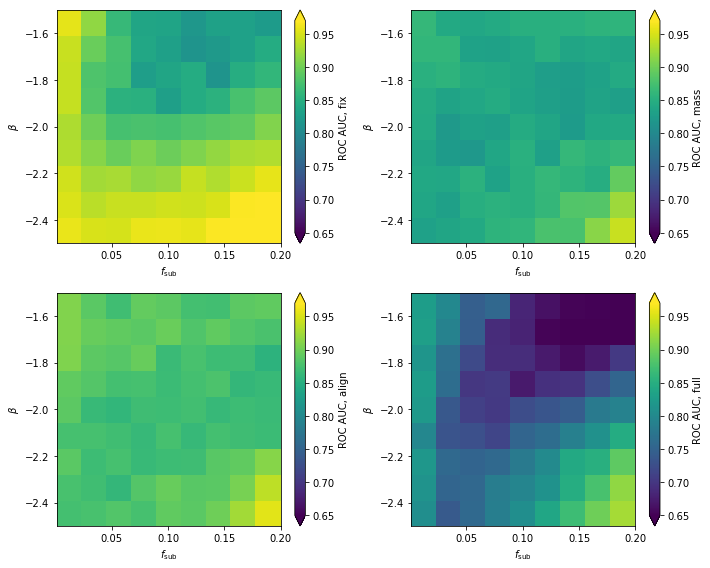

In [11]:
fig = plt.figure(figsize=(2*5,2*4))

for i, (label, roc_auc_) in enumerate(zip(summary_labels, roc_auc_regions)):
    ax = plt.subplot(2,2,i+1)
    
    pcm = ax.pcolormesh(
        f_sub_edges,
        beta_edges,
        roc_auc_.T,
        norm=matplotlib.colors.Normalize(vmin=0.65, vmax=0.97),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'ROC AUC, '+ label.lower())
    plt.xlim(f_sub_edges[0], f_sub_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/roc_by_parameter_region.pdf")
